In [21]:
# importing all modules
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.tri as tri
import matplotlib.ticker as mtick
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import LogFormatter 
from labellines import labelLine, labelLines
from collections import Counter

from functools import wraps

import csv
import sys

import itertools
from itertools import islice, cycle, chain

import scipy as sp
from scipy.interpolate import griddata
from scipy import interpolate
from scipy.integrate import odeint
from scipy.stats import pareto
from scipy.stats import loguniform

import seaborn as sns
import pandas as pd

import statistics as stats
import lhsmdu

from math import nan

from SALib.sample import saltelli, latin, ff
from SALib.analyze import sobol

import random

In [229]:
def f(s,t,temp, gamma):
    # ODE setup including recycling of nutrients
    g = 0.25
    n = 0.99
    alpha = (1.2e-7)*3**((temp-23)/10)
    Q = 0.022
    d = 1e-8
    m = (0.01)*3**((temp-23)/10)
    phi = 1e-10
    mu = 0.0441*np.exp(0.4991*temp) 
    beta = 75
    x = 0.3
    
    # set up solution matrix
    N = s[0]
    B = s[1]
    V = s[2]
  
    #systems of equations below
  
    dNdt = - alpha * (N / (N + Q)) * B + g * (alpha  * (N/(N+Q))*B) + (n * 1e-7 * (gamma) * phi * V * B) + 5e-11*m*V
    if N < 0:
        N = 0
    dBdt = (mu) * (N/(Q + N)) * B - gamma * phi * V * B - d*B
    if B < 1:
        B = 1
    dVdt =  gamma*beta * B * phi*V - phi * V * B -  m*V 
    if V < 1:
        V = 1
   
    #print (mu, beta, phi, gamma)
    return [dNdt, dBdt, dVdt]


In [230]:
def f2(s,t,temp, gamma):
    # Same as above, but without recycling
    
    g = 0.1
    n = 0.99
    alpha = (1.2e-7)*3**((temp-23)/10)
    Q = 0.022
    d = 1e-8
    m = (0.01)*3**((temp-23)/10)
    phi = 1e-10
    mu = 0.0441*np.exp(0.4991*temp) 
    beta = 75
    x = 0.3
    
    # set up solution matrix
    N = s[0]
    B = s[1]
    V = s[2]
  
    #systems of equations below
  
    dNdt = - alpha * (N / (N + Q)) * B + g * (alpha  * (N/(N+Q))*B) + 5e-11*m*V
    if N < 0:
        N = 0
    dBdt = (mu) * (N/(Q + N)) * B - gamma * phi * V * B - d*B
    if B < 1:
        B = 1
    dVdt =  gamma*beta * B * phi*V - phi * V * B -  m*V 
    if V < 1:
        V = 1
   
    #print (mu, beta, phi, gamma)
    return [dNdt, dBdt, dVdt]

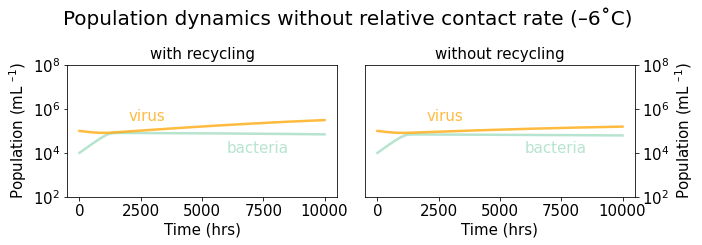

In [231]:
# define time, temperature scale
time = 10000
temp_list = np.linspace(-6, -6, 1)# [-12.5,-10, -8, -6, -4, -2]
t = np.linspace(1,time,1000)


plt.rcParams["font.family"] = "sans-serif"
fig1 = plt.figure(figsize=(10,3.5))
#fig1.tight_layout()
plt.rcParams.update({'font.size': 15})
fig1.suptitle('Population dynamics without relative contact rate (–6˚C) \n', size = 20)


# set up empty matricies, without RCR

Bactlist = []
Virlist = []
Nutslist = []
VBRlist = []
Bactlist2 = []
Virlist2 = []
Nutslist2 = []
VBRlist2 = []
count = 0


for xx in temp_list:
    temp = xx
    count += 1
    gamma = 1

    if temp < -1:
        RCR = 1 #0.0716*temp**4 + 2.9311*temp**3 + 34.108*temp**2 + 45.826*temp + 3.5125 #Fit from Wells and Deming, 2006
        BCF = 1 #-0.0106 * temp **2 - 0.519 * temp + 0.2977
        sal = 32 * BCF
    else:
        BCF = 1
        sal = 32
        
    s0=[0.12*BCF,1e4*BCF, 1e5*BCF]
    
    s = odeint(f,s0,t, args=(temp, gamma))
    s2 = odeint(f2,s0,t, args=(temp, gamma))
 
    nuts = s[:,0]
    bact = s[:,1]
    virus = s[:,2]
    
    nuts2 = s2[:,0]
    bact2 = s2[:,1]
    virus2 = s2[:,2]
    
    for k in range(0,len(bact)):
        if bact[k] < 1:
            bact[k] = 1
        if virus[k] < 1:
            virus[k] = 1
    
    for k in range(0,len(bact2)):
        if bact2[k] < 1:
            bact2[k] = 1
        if virus2[k] < 1:
            virus2[k] = 1
    
    
    Bactlist.append(bact)
    Virlist.append(virus)
    Nutslist.append(nuts)
    VBRlist.append(virus/bact)
   
    Bactlist2.append(bact2)
    Virlist2.append(virus2)
    Nutslist2.append(nuts2)
    VBRlist2.append(virus2/bact2)
   
                
  
Bactlist = np.array(Bactlist)
Virlist = np.array(Virlist)
Nutslist = np.array(Nutslist)
VBRlist = np.array(VBRlist)
Bactlist2 = np.array(Bactlist2)
Virlist2 = np.array(Virlist2)
Nutslist2 = np.array(Nutslist2)
VBRlist2 = np.array(VBRlist2)
    
# without RCR, with recycling
ax0 = fig1.add_subplot(121)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist[i,:], color = '#b7e4cF', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist[i,:], color = 'orange', label = '%s˚C' %(int(j)), alpha = 0.75, linewidth = 2.5)



#labelLines(plt.gca().get_lines(),  zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('with recycling', size = 15)
plt.xlabel('Time (hrs)')


# without RCR, without recycling
cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

ax1 = fig1.add_subplot(122)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist2[i,:], color = '#b7e4cF', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist2[i,:], color = 'orange', label = '%s˚C' %(int(j)), alpha = 0.75, linewidth = 2.5)
#plt.ylim(1e-5,10e6)
#labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('without recycling', size = 15)
#plt.xlabel('Time (hrs)')

#ax1.set_ylabel('Without RCR')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax0.set_ylim(1e2,1e8)
ax1.set_ylim(1e2,1e8)
ax0.set_yscale('log')
ax1.set_yscale('log')

ax0.text(2000, 3e5, "virus", color = 'orange', alpha = 0.75 )
ax0.text(6000, 1e4, "bacteria", color = '#b7e4cF')
ax1.text(2000, 3e5, "virus", color = 'orange', alpha = 0.75 )
ax1.text(6000, 1e4, "bacteria", color = '#b7e4cF')




plt.xlabel('Time (hrs)')
fig1.tight_layout()

fig1.subplots_adjust(top=0.75)




In [69]:
fig1.savefig('TimeDependent_16Jan_noRCR_comparison.png', dpi=300)

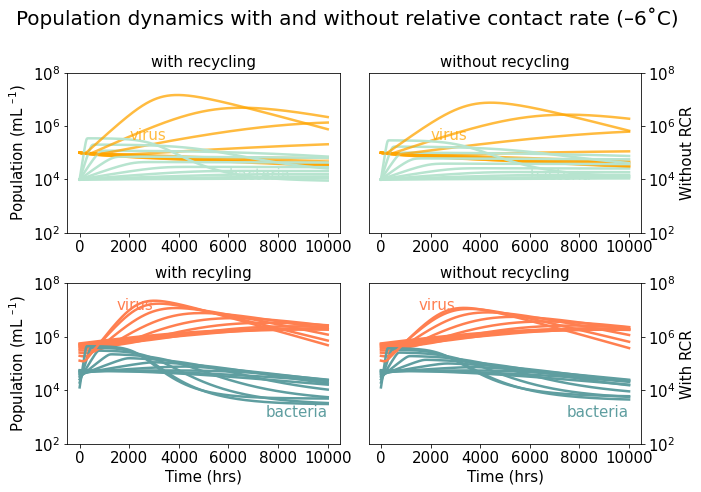

In [232]:
# define time, temperature scale
time = 10000
temp_list = np.linspace(-15, -2, 10)# [-12.5,-10, -8, -6, -4, -2]
t = np.linspace(1,time,1000)


plt.rcParams["font.family"] = "sans-serif"
fig1 = plt.figure(figsize=(10,7))
#fig1.tight_layout()
plt.rcParams.update({'font.size': 15})
fig1.suptitle('Population dynamics with and without relative contact rate (–6˚C) \n', size = 20)


# set up empty matricies, without RCR with (f; X) and without recycling (f2; 2)

Bactlist = []
Virlist = []
Nutslist = []
VBRlist = []
Bactlist2 = []
Virlist2 = []
Nutslist2 = []
VBRlist2 = []
count = 0


for xx in temp_list:
    temp = xx
    count += 1
    gamma = 1

    if temp < -1:
        RCR = 1 #0.0716*temp**4 + 2.9311*temp**3 + 34.108*temp**2 + 45.826*temp + 3.5125 #Fit from Wells and Deming, 2006
        BCF = 1 #-0.0106 * temp **2 - 0.519 * temp + 0.2977
        sal = 32 * BCF
    else:
        BCF = 1
        sal = 32
        
    s0=[0.12*BCF,1e4*BCF, 1e5*BCF]
    
    s = odeint(f,s0,t, args=(temp, gamma))
    s2 = odeint(f2,s0,t, args=(temp, gamma))
 
    nuts = s[:,0]
    bact = s[:,1]
    virus = s[:,2]
    
    nuts2 = s2[:,0]
    bact2 = s2[:,1]
    virus2 = s2[:,2]
    
    for k in range(0,len(bact)):
        if bact[k] < 1:
            bact[k] = 1
        if virus[k] < 1:
            virus[k] = 1
    
    for k in range(0,len(bact2)):
        if bact2[k] < 1:
            bact2[k] = 1
        if virus2[k] < 1:
            virus2[k] = 1
    
    
    Bactlist.append(bact)
    Virlist.append(virus)
    Nutslist.append(nuts)
    VBRlist.append(virus/bact)
   
    Bactlist2.append(bact2)
    Virlist2.append(virus2)
    Nutslist2.append(nuts2)
    VBRlist2.append(virus2/bact2)
   
                
  
Bactlist = np.array(Bactlist)
Virlist = np.array(Virlist)
Nutslist = np.array(Nutslist)
VBRlist = np.array(VBRlist)
Bactlist2 = np.array(Bactlist2)
Virlist2 = np.array(Virlist2)
Nutslist2 = np.array(Nutslist2)
VBRlist2 = np.array(VBRlist2)
    
# without RCR, with recycling
ax0 = fig1.add_subplot(221)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist[i,:], color = '#b7e4cF', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist[i,:], color = 'orange', label = '%s˚C' %(int(j)), alpha = 0.75, linewidth = 2.5)



#labelLines(plt.gca().get_lines(),  zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('with recycling', size = 15)
#plt.xlabel('Time (hrs)')


# without RCR, without recycling
cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

ax1 = fig1.add_subplot(222)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist2[i,:], color = '#b7e4cF', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist2[i,:], color = 'orange', label = '%s˚C' %(int(j)), alpha = 0.75, linewidth = 2.5)
#plt.ylim(1e-5,10e6)
#labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('without recycling', size = 15)
#plt.xlabel('Time (hrs)')

ax1.set_ylabel('Without RCR')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax0.set_ylim(1e2,1e8)
ax1.set_ylim(1e2,1e8)
ax0.set_yscale('log')
ax1.set_yscale('log')

ax0.text(2000, 3e5, "virus", color = 'orange', alpha = 0.75 )
ax0.text(6000, 1e4, "bacteria", color = '#b7e4cF')
ax1.text(2000, 3e5, "virus", color = 'orange', alpha = 0.75 )
ax1.text(6000, 1e4, "bacteria", color = '#b7e4cF')



# ------------------------------------------------------------- #
#with RCR, with (f; 3) and without (f2; 4) recycling

Bactlist3 = []
Virlist3 = []
Nutslist3 = []
VBRlist3 = []
Bactlist4 = []
Virlist4 = []
Nutslist4 = []
VBRlist4 = []


count = 0
for xx in temp_list:
    temp = xx
    count += 1
    gamma = 1

    if temp < -1:
        RCR = 0.0716*temp**4 + 2.9311*temp**3 + 34.108*temp**2 + 45.826*temp + 3.5125 #Fit from Wells and Deming, 2006
        BCF = -0.0106 * temp **2 - 0.519 * temp + 0.2977
        sal = 32 * BCF
    else:
        BCF = 1
        sal = 32
        
    s0=[0.12*BCF,1e4*BCF, 1e5*BCF]
    
    s = odeint(f,s0,t, args=(temp, gamma))
    s2 = odeint(f2,s0,t, args=(temp, gamma))
 
    nuts3 = s[:,0]
    bact3 = s[:,1]
    virus3 = s[:,2]
    
    nuts4 = s2[:,0]
    bact4 = s2[:,1]
    virus4 = s2[:,2]
    
    for k in range(0,len(bact3)):
        if bact3[k] < 1:
            bact3[k] = 1
        if virus3[k] < 1:
            virus3[k] = 1
    
    for k in range(0,len(bact4)):
        if bact4[k] < 1:
            bact4[k] = 1
        if virus4[k] < 1:
            virus4[k] = 1
    
    
    Bactlist3.append(bact3)
    Virlist3.append(virus3)
    Nutslist3.append(nuts3)
    VBRlist3.append(virus3/bact3)
   
    Bactlist4.append(bact4)
    Virlist4.append(virus4)
    Nutslist4.append(nuts4)
    VBRlist4.append(virus4/bact4)
   
                
  
Bactlist3 = np.array(Bactlist3)
Virlist3 = np.array(Virlist3)
Nutslist3 = np.array(Nutslist3)
VBRlist3 = np.array(VBRlist3)
Bactlist4 = np.array(Bactlist4)
Virlist4 = np.array(Virlist4)
Nutslist4 = np.array(Nutslist4)
VBRlist4 = np.array(VBRlist4)

cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

# with RCR, with recycling
ax0 = fig1.add_subplot(223)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist3[i,:], color = 'cadetblue', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist3[i,:], color = 'coral', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)


#labelLines(plt.gca().get_lines(),  zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('with recyling', size = 15)
plt.xlabel('Time (hrs)')


# with RCR, without recycling
cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

ax1 = fig1.add_subplot(224)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(t, Bactlist4[i,:], color = 'cadetblue', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(t, Virlist4[i,:], color = 'coral', label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
#plt.ylim(1e-5,10e6)
#labelLines(plt.gca().get_lines(), zorder=2.5, fontsize=10) #color = 'k')
plt.ylabel('Population (mL $^{–1}$)')
plt.title('without recycling', size = 15)
plt.xlabel('Time (hrs)')

ax1.set_ylabel('With RCR')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax0.set_ylim(1e2,1e8)
ax1.set_ylim(1e2,1e8)
ax0.set_yscale('log')
ax1.set_yscale('log')

ax0.text(1500, 1e7, "virus", color = 'coral' )
ax0.text(7500, 1e3, "bacteria", color = 'cadetblue')
ax1.text(1500, 1e7, "virus", color = 'coral')
ax1.text(7500, 1e3, "bacteria", color = 'cadetblue')



plt.xlabel('Time (hrs)')
fig1.tight_layout()

fig1.subplots_adjust(top=0.85)




In [81]:
#fig1.savefig('TimeDependent_16Jan_all_comparison.png', dpi=300)

5


Text(0.5, 0, 'Bacterial population (mL $^{–1}$)')

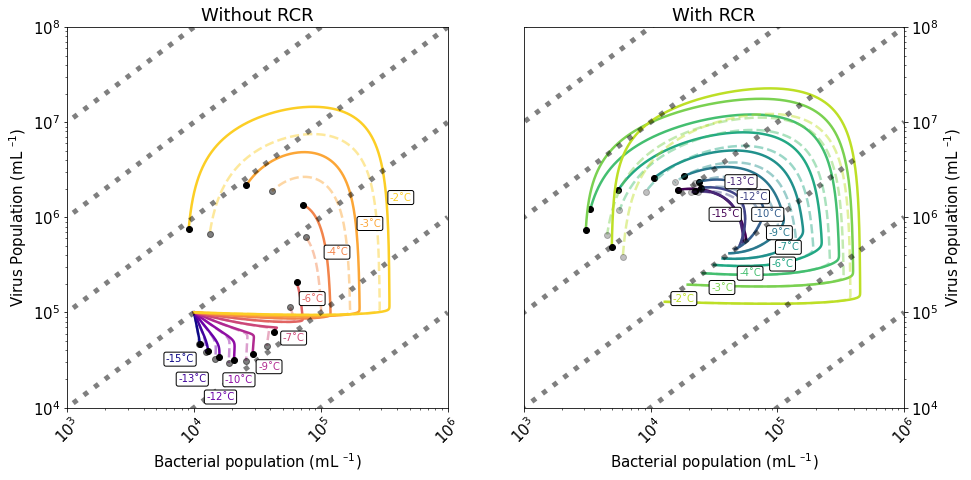

In [364]:
cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

cm = plt.get_cmap('plasma')
colorlist2 = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

fig2 = plt.figure(figsize=(15,7))

lengths = int(len(temp_list))
halflen = int(lengths/2)
print (halflen)

x1_man= [3e4, 4e4, 5e4, 6.5e4, 8.5e4, 1e5, 9e4, 5e4, 3e4, 1.5e4]
y1_man = [1e6, 2.2e6, 1.53e6, 1e6, 6.4e5, 4.5e5, 3e5, 2.4e5, 1.7e5 ,1.3e5]

# with RCR, recycling (3)
ax1 = fig2.add_subplot(122)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(Bactlist3[i,:], Virlist3[i,:], color = colorlist[i], label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(Bactlist3[i,-1], Virlist3[i,-1], 'ko')
    plt.plot(Bactlist4[i,:], Virlist4[i,:], color = colorlist[i], label = '%s˚C' %(int(j)), linewidth = 2.5, ls = '--', alpha = 0.45)
    plt.plot(Bactlist4[i,-1], Virlist4[i,-1], 'ko', alpha = 0.25)
    ax1.text((x1_man[i]), (y1_man[i]), '%s˚C' %(int(j)), color = colorlist[i], size = 10, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))


    #ax1.text(Bactlist[i,-1]+ 100, Virlist[i,-1]+ 100, 't$_{end}$')


plt.xlabel('Bacterial population (mL $^{–1}$)')
plt.xticks(rotation=45)
plt.plot([1, 1e6], [0.1, 1e5], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [1, 1e6], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [10, 1e7], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [100, 1e8], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [1000, 1e9], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [10000, 1e10], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [100000, 1e11], 'k:', alpha = 0.5, linewidth = 5)


x2_man= [6000,7500,12500, 17500, 3.2e4, 5e4, 7e4, 1.1e5, 2e5, 3.5e5]
y2_man = [3e4, 1.85e4, 1.2e4, 1.82e4, 2.5e4, 5e4, 1.3e5, 4e5, 8e5 , 1.5e6]

#without RCR, with recycling (X)
ax0 = fig2.add_subplot(121)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(Bactlist[i,:], Virlist[i,:], color = colorlist2[i], label = '%s˚C' %(int(j)), linewidth = 2.5)#, ls = '--')
    plt.plot(Bactlist[i,-1], Virlist[i,-1], 'ko')
    plt.plot(Bactlist2[i,:], Virlist2[i,:], color = colorlist2[i], label = '%s˚C' %(int(j)), linewidth = 2.5, ls = '--', alpha = 0.45)
    plt.plot(Bactlist2[i,-1], Virlist2[i,-1], 'ko', alpha = 0.5)
    ax0.text((x2_man[i]), (y2_man[i]), '%s˚C' %(int(j)), color = colorlist2[i], size = 10, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))
    #plt.plot(Bactlist2[i,0], Virlist2[i,0], 'kD')


ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.ylim(100,1.1e7)
#plt.xscale('log')
ax0.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.xticks(rotation=45)

# add vbr lines
plt.plot([1, 1e6], [0.1, 1e5], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [1, 1e6], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [10, 1e7], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [100, 1e8], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [1000, 1e9], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [10000, 1e10], 'k:', alpha = 0.5, linewidth = 5)
plt.plot([1, 1e6], [100000, 1e11], 'k:', alpha = 0.5, linewidth = 5)





ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')


ax0.set_ylim(1e4,1e8)
ax1.set_ylim(1e4,1e8)
ax0.set_xlim(1e3,1e6)
ax1.set_xlim(1e3,1e6)

ax1.set_ylabel('Virus Population (mL $^{–1}$)')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax0.set_title('Without RCR')
ax1.set_title('With RCR')


plt.ylabel('Virus Population (mL $^{–1}$)')
plt.xlabel('Bacterial population (mL $^{–1}$)')
#plt.title('Stability Plot of ODE Equations')


In [365]:
fig2.savefig('PhasePortrait_noannot_17Jan.png', dpi=300)

In [184]:
print (Nutslist)

[[6.83724000e-01 6.82962657e-01 6.82201601e-01 ... 1.99131295e-01
  1.98929641e-01 1.98728353e-01]
 [6.46230074e-01 6.45387453e-01 6.44544915e-01 ... 4.32313819e-02
  4.29949492e-02 4.27593274e-02]
 [6.03428296e-01 6.02507439e-01 6.01586171e-01 ... 2.48868223e-04
  2.48843869e-04 2.48819193e-04]
 ...
 [3.09801630e-01 3.08770025e-01 3.07701213e-01 ... 1.94622766e-04
  1.94081712e-04 1.93541730e-04]
 [2.35152741e-01 2.34237123e-01 2.33253366e-01 ... 1.43040758e-04
  1.42487106e-04 1.41935162e-04]
 [1.55196000e-01 1.54492977e-01 1.53682961e-01 ... 5.56855579e-05
  5.53677928e-05 5.50517397e-05]]


Text(0.5, 0, 'Bacterial population (mL $^{–1}$)')

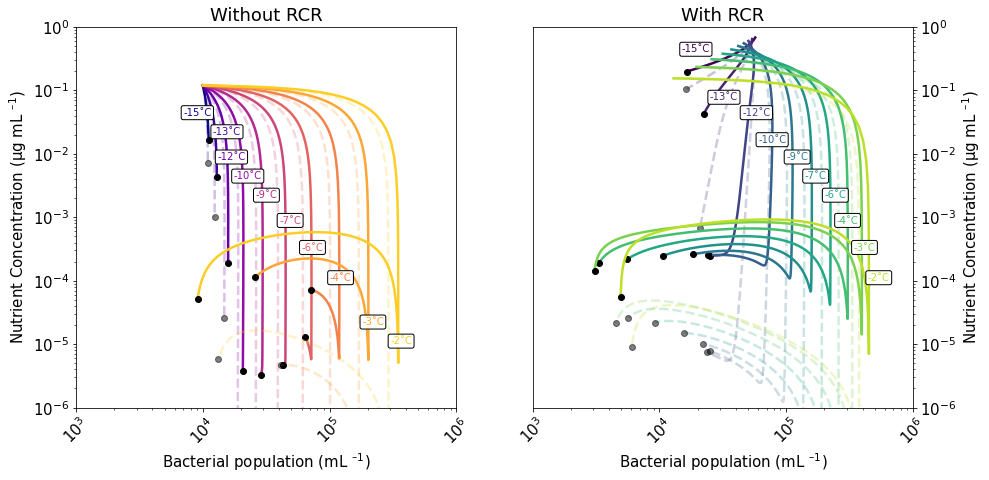

In [406]:
cm = plt.get_cmap('viridis')
colorlist = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

cm = plt.get_cmap('plasma')
colorlist2 = [cm(1.*i/len(temp_list)) for i in range(0,len(temp_list))]

fig3 = plt.figure(figsize=(15,7))


x3_man= [1.5e4, 2.5e4, 4.5e4, 6e4, 1e5, 1.4e5, 2e5, 2.5e5, 3.4e5, 4.4e5]
y3_man = [4e-1, 7e-2, 4e-2, 1.5e-2, 8e-3, 4e-3, 2e-3, 8e-4, 3e-4, 1e-4]

# With RCR, with recycling (3)
ax1 = fig3.add_subplot(122)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(Bactlist3[i,:], Nutslist3[i,:], color = colorlist[i], label = '%s˚C' %(int(j)), alpha = 1, linewidth = 2.5)
    plt.plot(Bactlist3[i,-1], Nutslist3[i,-1], 'ko')
    plt.plot(Bactlist4[i,:], Nutslist4[i,:], color = colorlist[i], label = '%s˚C' %(int(j)), linewidth = 2.5, ls = '--', alpha = 0.25)
    plt.plot(Bactlist4[i,-1], Nutslist4[i,-1], 'ko', alpha = 0.5)
    ax1.text((x3_man[i]), (y3_man[i]), '%s˚C' %(int(j)), color = colorlist[i], size = 10, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))



plt.xlabel('Bacterial population (mL $^{–1}$)')
plt.xticks(rotation=45)


x4_man= [7e3, 1.2e4, 1.3e4, 1.75e4, 2.6e4, 4e4, 6e4, 1e5, 1.8e5, 3e5]
y4_man = [4e-2, 2e-2, 8e-3, 4e-3, 2e-3, 8e-4, 3e-4, 1e-4, 2e-5, 1e-5]

#without RCR, withour recycling
ax0 = fig3.add_subplot(121)    
for i,j in zip(range(0,len(temp_list)), temp_list):
    plt.plot(Bactlist[i,:], Nutslist[i,:], color = colorlist2[i], label = '%s˚C' %(int(j)), linewidth = 2.5)#, ls = '--')
    plt.plot(Bactlist[i,-1], Nutslist[i,-1], 'ko')
    plt.plot(Bactlist2[i,:], Nutslist2[i,:], color = colorlist2[i], label = '%s˚C' %(int(j)), linewidth = 2.5, ls = '--', alpha = 0.25)
    plt.plot(Bactlist2[i,-1], Nutslist2[i,-1], 'ko', alpha = 0.5)
    ax0.text((x4_man[i]), (y4_man[i]), '%s˚C' %(int(j)), color = colorlist2[i], size = 10, bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))

    
ax0.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
#plt.ylim(100,1.1e7)
#plt.xscale('log')
ax0.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.xticks(rotation=45)





#fig3.colorbar(templist, orientation="horizontal", pad=0.2)



ax0.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')



ax0.set_ylim(1e-6,1e0)
ax1.set_ylim(1e-6,1e0)
ax0.set_xlim(1e3,1e6)
ax1.set_xlim(1e3,1e6)

ax1.set_ylabel('Nutrient Concentration (µg mL $^{–1}$)')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax0.set_title('Without RCR')
ax1.set_title('With RCR')


plt.ylabel('Nutrient Concentration (µg mL $^{–1}$)')
plt.xlabel('Bacterial population (mL $^{–1}$)')
#plt.title('Stability Plot of ODE Equations')



In [407]:
fig3.savefig('PhasePortrait_nuts_17Jan.png', dpi=300)